Compare SVM and LS-SVM (and decide on the kernel function) on the ozon level detec-
tion data set on Blackboard (see https://archive.ics.uci.edu/ml/datasets/Ozone+Level+Detection). This data set contains 72 measurement variables and was measured between 1/1/1998 and 12/31/2004.
All missing values have been removed. The goal is to detect detect whether there was too much
ozon (class label 0) or a normal day (class label 1). The class label is the last variable. Set up
the simulation and clearly describe what you are doing and why. Finally, state, according to your
findings (boxplots, ROC curves, etc.), the best classifier for this problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import grid_search
from sklearn.cross_validation import cross_val_score
from scipy.stats import uniform
from scipy.stats import norm
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn import preprocessing
%matplotlib inline

In [1]:
# load data in dataframe
col_names = ['X' + str(i) for i in range(73)]
data = pd.read_excel("ozon.xlsx", header = None, names = col_names)

NameError: name 'pd' is not defined

In [3]:
#define x and y
feature_cols = ['X' + str(i) for i in range(72)]
x = data[feature_cols]
y = data.X72
data['X72'] = data['X72'].replace([0, 1], [-1, 1]) 
y = data.X72
#data.shape

### Find optimal hyper-parameters for kernel, c, and gamma in SVM using randomized search cv
Using linear, rbf, and polynomial kernels. For each kernel, run 100 simulations using randomizedSearchCV, we will then plot the ROC of each to see the accuracy and compare this with ROC of LS-SVM with the same kernels.

##### Linear Kernel

In [5]:
accuracy_scores = []
best_C_arr = []

# 100 simulations with rbf
for i in range(100): 
    # split data in training and testing sets 70/30 train/test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 553, train_size = 1292)

    C_range = np.arange(0.0001, 200, 0.05)

    # Check that C>0 
    C_range[C_range < 0] = 0.0001

    hyperparameters = { 'C': list(C_range)}

    # Run randomized search with range of hyperparameter values
    svm = SVC(kernel='linear', probability=True)
    randomCV = RandomizedSearchCV(svm, param_distributions=hyperparameters, n_iter=20)
    randomCV.fit(x_train, y_train)

    # Identify optimal hyperparameter values
    best_C = randomCV.best_params_['C']
    best_C_arr.append(best_C)

    # Train SVM and output predictions
    linearSVM = SVC(kernel='linear', C=best_C)
    linearSVM.probability = True
    linearSVM.fit(x_train, y_train)
    svm_predictions = linearSVM.predict(x_test)
    y_pred = linearSVM.predict(x_test)
    accuracy_scores.append(metrics.accuracy_score(y_test, y_pred))

print(np.array(best_C_arr).mean())
print(max(accuracy_scores))
print(np.array(accuracy_scores).mean())

83.4501
0.942133815552
0.937613019892


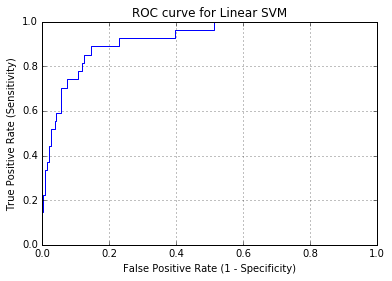

In [8]:
# Use the optimal parameters to make a final model
# split data in training and testing sets 70/30 train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 553, train_size = 1292)


# fit with with best C
svm = SVC(C=83.45, kernel='linear', probability=True)
svm.fit(x_train, y_train)
svm_predictions = svm.predict(x_test)
y_pred = svm.predict(x_test)
y_pred_prob = svm.predict_proba(x_test)[:, 1]
    
#first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Linear SVM')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [9]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.92233488241092798

#### RBF kernel

In [4]:
accuracy_scores = []
best_C_arr = []
best_g_arr = []

# 100 simulations with rbf
for i in range(100):    
    # split data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 553, train_size = 1292)
    Cs = np.linspace(0.001, 1001.0, num=2000, endpoint=False)

    # Designate distributions to sample hyperparameters from 
    np.random.seed(123)
    g_range = np.random.uniform(0.0, 2.3, 60).astype(float)
    C_range = np.random.normal(0.1, 14.0, 100).astype(float)

    # Check that gamma>0 and C>0 
    C_range[C_range < 0] = 0.0001

    hyperparameters = {'gamma': list(g_range), 
                        'C': list(C_range)}


    # Run randomized search with range of hyperparameter values
    svm = SVC(kernel='rbf', probability=True)
    randomCV = RandomizedSearchCV(svm, param_distributions=hyperparameters, n_iter=20)
    randomCV.fit(x_train, y_train)

    # Identify optimal hyperparameter values and add to list
    best_gamma  = randomCV.best_params_['gamma']
    best_C      = randomCV.best_params_['C']
    best_C_arr.append(best_C)
    best_g_arr.append(best_gamma)
    
    # Train SVM and output predictions
    rbfSVM = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
    rbfSVM.probability=True
    rbfSVM.fit(x_train, y_train)
    svm_predictions = rbfSVM.predict(x_test)
    y_pred_prob = rbfSVM.predict_proba(x_test)[:, 1]
    y_pred = rbfSVM.predict(x_test)
    accuracy_scores.append(metrics.accuracy_score(y_test, y_pred))
    
print(max(accuracy_scores))
print(np.array(accuracy_scores).mean())
print(np.array(best_C_arr).mean())
print(np.array(best_g_arr).mean())
y_pred = rbfSVM.predict(x_test)
y_pred_prob = rbfSVM.predict_proba(x_test)[:, 1]

0.94575045208
0.938517179024
10.0717048966
1.43509178912


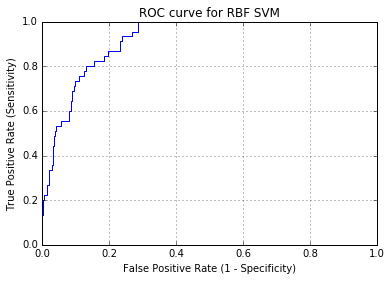

In [13]:
# Use the optimal parameters to make a final model
# split data in training and testing sets 70/30 train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 553, train_size = 1292)


# fit with with best C and g
svm = SVC(C=10.07, kernel='rbf', gamma=1.43,probability=True)
svm.fit(x_train, y_train)
svm_predictions = svm.predict(x_test)
y_pred = svm.predict(x_test)
y_pred_prob = svm.predict_proba(x_test)[:, 1]

#first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for RBF SVM')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [12]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.9235858727052465

#### Polynomial Kernel

In [4]:
accuracy_scores = []
best_C_arr = []
best_degree_arr = []

# 100 simulations with polynomial
for i in range(100): 
    #Normalize the data to use with range of parameters for polynomial kernel
    x1 = preprocessing.scale(x)

    # split data
    x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size = 553, train_size = 1292)

    # range of c and degree values
    C_values = np.logspace(-5, 7, 4)
    degree_values= [1,2,3,4,5]
    hyperparameters = {'C':C_values, 'degree': degree_values}

    # Run randomized search with range of values
    svm = SVC(kernel='poly', probability=True)
    polySVM = RandomizedSearchCV(svm, param_distributions=hyperparameters, n_iter=20)

    #fit the model
    polySVM.fit(x_train, y_train)

    # Identify optimal hyperparameter values
    best_degree  = polySVM.best_params_['degree']
    best_C      = polySVM.best_params_['C']
    best_C_arr.append(best_C)
    best_degree_arr.append(best_degree)

    # Train SVM and output predictions
    polySVM.probability = True
    polySVM = SVC(kernel='poly', C=best_C, degree=best_degree)
    polySVM.fit(x_train, y_train)
    svm_predictions = polySVM.predict(x_test)
    y_pred = polySVM.predict(x_test)
    accuracy_scores.append(metrics.accuracy_score(y_test, y_pred))

print(max(accuracy_scores))
print(np.array(accuracy_scores).mean())
y_pred = polySVM.predict(x_test)
y_pred_prob = polySVM.predict_proba(x_test)[:, 1]

0.940325497288
0.936708860759


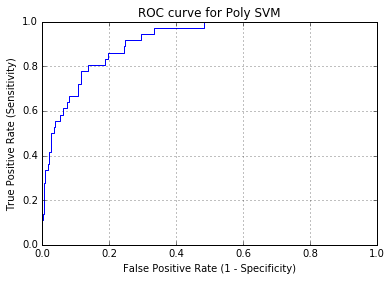

In [5]:
# Use the optimal parameters to make a final model
# split data in training and testing sets 70/30 train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 553, train_size = 1292)


# fit with with best C and g
svm = SVC(C=20.69, kernel='poly', degree=1,probability=True)
svm.fit(x_train, y_train)
svm_predictions = svm.predict(x_test)
y_pred = svm.predict(x_test)
y_pred_prob = svm.predict_proba(x_test)[:, 1]

#first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Poly SVM')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [6]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.91381904147861592

## LS-SVM
like SVM, we will get the best kernel and hyperparameters for LS-SVM and compare that with SVM performance  
Scikit learn does not have an LS-SVM function so matlab will be used for the LS-SVM portion